In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import six
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from glob import glob
import deepdish as dd
import h5py


def plot_image(axes, image):
    axes.grid(False)
    axes.imshow(image)
    axes.set_xlim(0, image.shape[1])
    axes.set_ylim(image.shape[0], 0)
    axes.axis('off')

def plot_keypoints(axes, keypoints, color):
    x = [kp[1] for kp in keypoints]
    y = [kp[0] for kp in keypoints]
    axes.scatter(x, y, c=color, marker='.', edgecolors='none')

def get_crop_range(xx, yy, half_width):
    """Function for retrieving the crop coordinates"""

    xs = np.cast['int'](np.round(xx - half_width))
    xe = np.cast['int'](np.round(xx + half_width))
    ys = np.cast['int'](np.round(yy - half_width))
    ye = np.cast['int'](np.round(yy + half_width))

    return xs, xe, ys, ye

def crop_patch(img, cx, cy, clockwise_rot, resize_ratio, nPatchSize):
    """Crops the patch.
    Crops with center at cx, cy with patch size of half_width and resizes to
    nPatchSize x nPatchsize patch.
    Parameters
    ----------
    img: np.ndarray
        Input image to be cropped from.
    cx: float
        x coordinate of the patch.
    cy: float
        y coordinate of the patch.
    clockwise_rot: float (degrees)
        clockwise rotation to apply when extracting
    resize_ratio: float
        Ratio of the resize. For example, ratio of two will crop a 2 x
        nPatchSize region.
    nPatchSize: int
        Size of the returned patch.
    Notes
    -----
    The cv2.warpAffine behaves in similar way to the spatial transformers. The
    M matrix should move coordinates from the original image to the patch,
    i.e. inverse transformation.
    """

    # First, undo the scaling and check for out bounds
    half_sigma = resize_ratio * nPatchSize / 2
    safety = 1.1 * np.sqrt(2) * half_sigma
    if cx - safety < 0 or cx + safety >= img.shape[1] or \
        cy - safety < 0 or cy + safety >= img.shape[0]:
        return None
    
    # Below equation should give (nPatchSize-1)/2 when M x [cx, 0, 1]',
    # 0 when M x [cx - (nPatchSize-1)/2*resize_ratio, 0, 1]', and finally,
    # nPatchSize-1 when M x [cx + (nPatchSize-1)/2*resize_ratio, 0, 1]'.
    dx = (nPatchSize - 1.0) * 0.5 - cx / resize_ratio
    dy = (nPatchSize - 1.0) * 0.5 - cy / resize_ratio
    M = np.asarray([[1. / resize_ratio, 0.0, dx],
                    [0.0, 1. / resize_ratio, dy],
                    [0.0, 0.0, 1.0]])
    # move to zero base before rotation
    R_pre = np.asarray([[1.0, 0.0, -(nPatchSize - 1.0) * 0.5],
                        [0.0, 1.0, -(nPatchSize - 1.0) * 0.5],
                        [0.0, 0.0, 1.0]])
    # rotate
    theta = clockwise_rot / 180.0 * np.pi
    R_rot = np.asarray([[np.cos(theta), -np.sin(theta), 0.0],
                        [np.sin(theta), np.cos(theta), 0.0],
                        [0.0, 0.0, 1.0]])
    # move back to corner base
    R_post = np.asarray([[1.0, 0.0, (nPatchSize - 1.0) * 0.5],
                         [0.0, 1.0, (nPatchSize - 1.0) * 0.5],
                         [0.0, 0.0, 1.0]])
    # combine
    R = np.dot(R_post, np.dot(R_rot, R_pre))

#     print(resize_ratio)
#     print(nPatchSize)
    crop = cv2.warpAffine(img, np.dot(R, M)[:2, :], (nPatchSize, nPatchSize))

    return crop

# https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
# ignore orientation, for simplicity
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

/cvlabdata1/cvlab/datasets_eduard/colmap/reichstag/dense/images/48403953_4568435171.jpg


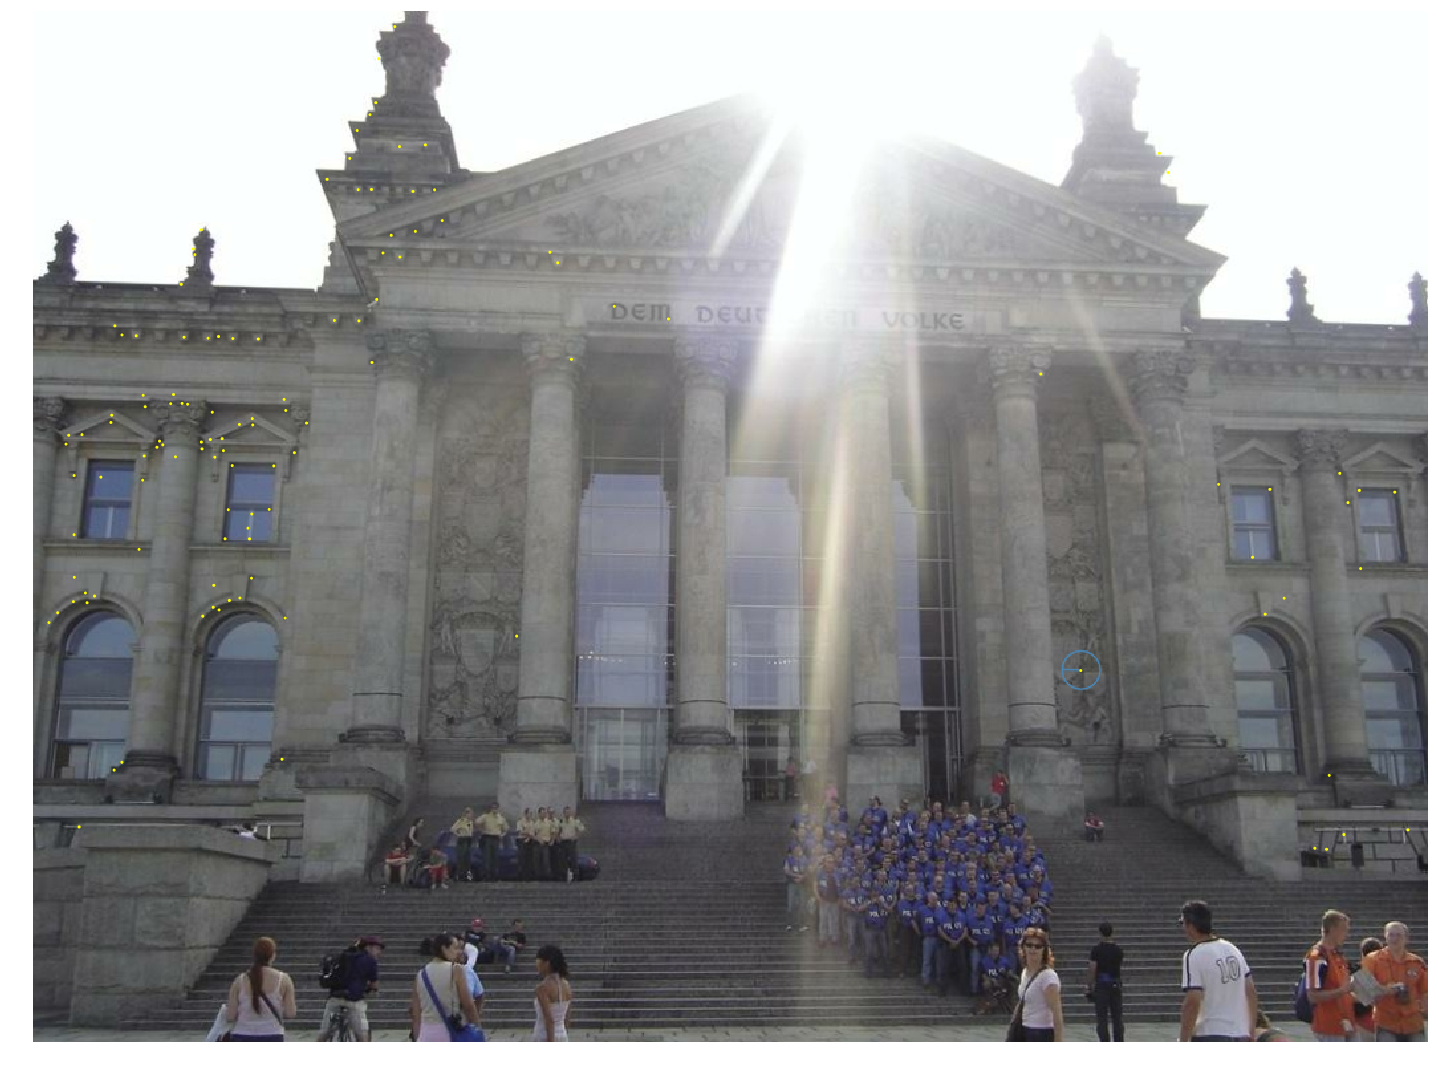

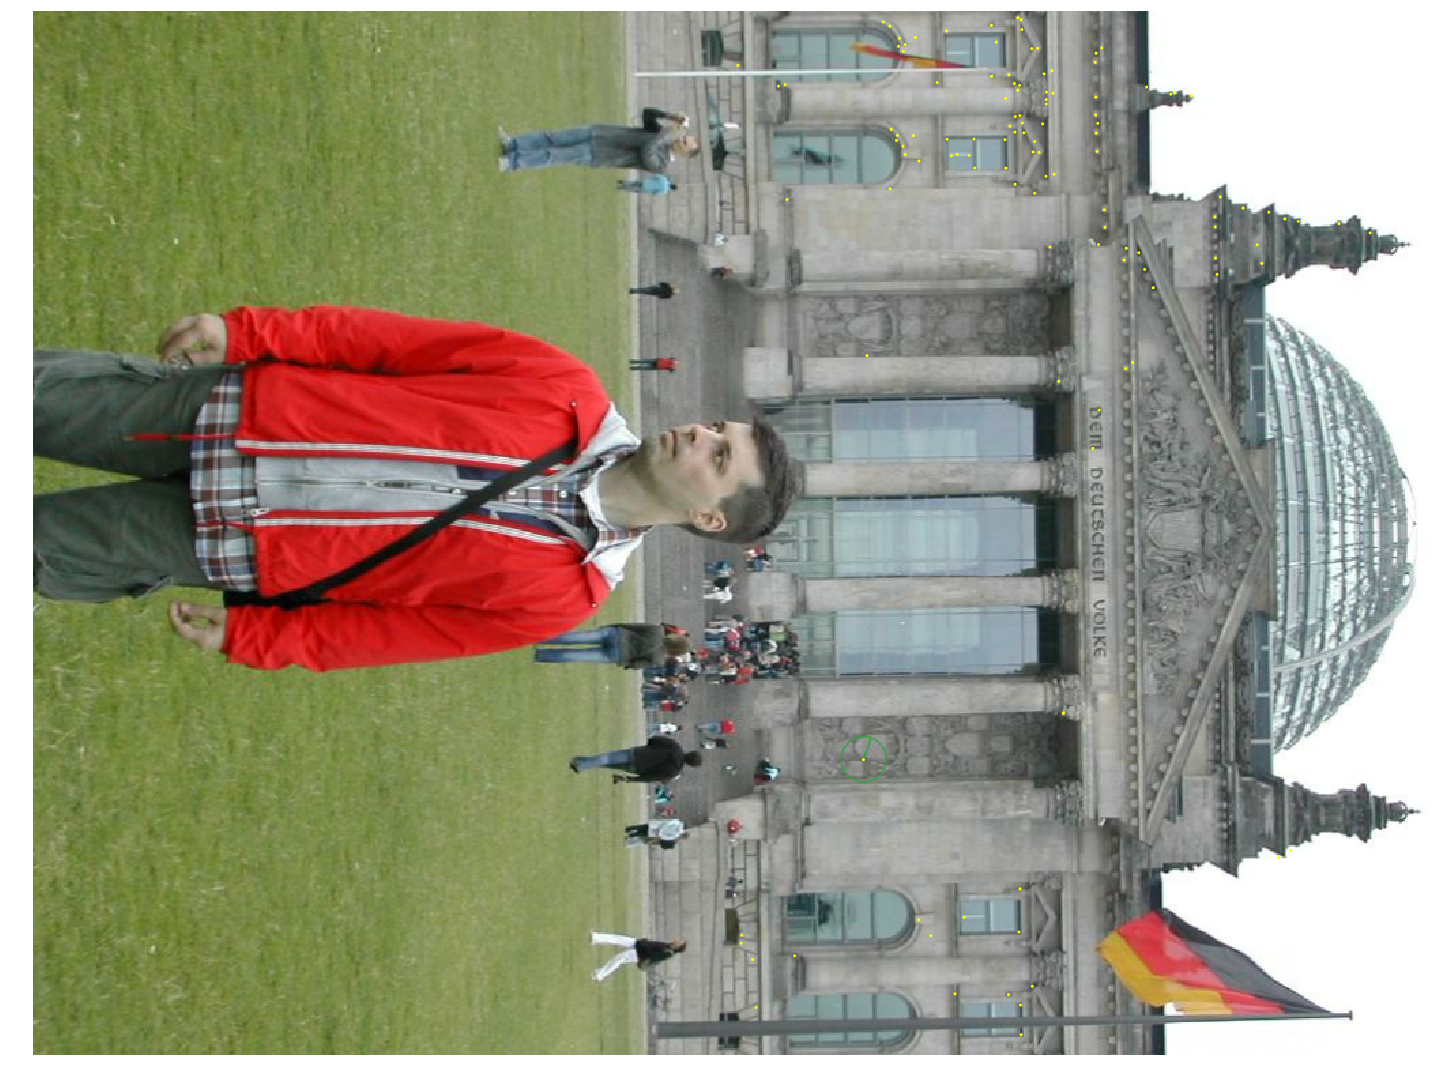

In [421]:
import os
from glob import glob

seq = 'reichstag'
folder_images = '/cvlabdata1/cvlab/datasets_eduard/colmap/{}/dense/images'.format(seq)
folder_pairs = '/cvlabdata1/cvlab/datasets_eduard/colmap-patches-fix/{}/out-pairs-2000-kps-2000'.format(seq)
folder_outp = '/home/trulls/tmp/debug/{}'.format(seq)

if not os.path.isdir(folder_outp):
  os.makedirs(folder_outp)

# file_pairs = 'pair_62751178_369337490-63812586_393800330_SIFT.npy'
all_pairs = glob('{}/pair_*SIFT.npy'.format(folder_pairs))
file_pairs = all_pairs[5].split('/')[-1]
# file_pairs = all_pairs[62].split('/')[-1]
# file_pairs = all_pairs[100].split('/')[-1]

fim1, fim2 = [f + '.jpg' for f in file_pairs[5:-9].split('-')]
print(folder_images + '/' + fim1)
im1 = cv2.cvtColor(cv2.imread(folder_images + '/' + fim1), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread(folder_images + '/' + fim2), cv2.COLOR_BGR2RGB)
points, scales, oris, pair_id, oridiff, kp_id, scalemap = np.load('{}/{}'.format(folder_pairs, file_pairs))
# print(scalemap)
# print([o * 180 / np.pi for o in oridiff])

fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111)
k1, k2 = 0, 1
sm = 12
cvkp1 = [cv2.KeyPoint(p[0], p[1], sm*s, o) for p, s, o in zip(points[0], scales[0], oris[0])]
im1_plot = cv2.drawKeypoints(im1, cvkp1[k1:k2], None, None, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plot_image(axes, im1_plot)
plot_keypoints(axes, points[0][:, ::-1], 'yellow')
fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111)
cvkp2 = [cv2.KeyPoint(p[0], p[1], sm*s, o) for p, s, o in zip(points[1], scales[1], oris[1])]
im2_plot = cv2.drawKeypoints(im2, cvkp2[k1:k2], None, None, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plot_image(axes, im2_plot)
plot_keypoints(axes, points[1][:, ::-1], 'yellow')

In [424]:
th_scale = 1.25
th_ori = 22.5

lmb = 12
ps = 64
n = points[0].shape[0]
for i in range(k1, k2):
    diff_scale = scales[0][i] / (scales[1][i] * scalemap[i])
    diff_scale = diff_scale if diff_scale > 1 else 1 / diff_scale
    orimap = oridiff[i] * 180 / np.pi
    orimap = orimap if orimap <= 180 else 360 - orimap
    diff_ori = oris[0][i] - oris[1][i] + orimap
    diff_ori = diff_ori if diff_ori < 180 else 360 - diff_ori
    diff_ori_abs = np.abs(diff_ori)
    print('Scale {}, ori {}, bias scale {}, bias ori {}'.format(diff_scale, diff_ori, scalemap[i], orimap))
    if diff_scale > th_scale or diff_ori_abs > th_ori:
        print('Skipping!')
        continue
    
    oria, orib = -oris[0][i], -oris[1][i]
#     oria, orib = 0, 0
    p1 = crop_patch(im1, int(points[0][i, 0]), int(points[0][i, 1]), oria, lmb*scales[0][i]/ps, ps)
    p2_gt = crop_patch(im2, int(points[1][i, 0]), int(points[1][i, 1]), oria - orimap, lmb*scales[0][i]/ps/scalemap[i], ps)
    p2 = crop_patch(im2, int(points[1][i, 0]), int(points[1][i, 1]), orib, lmb*scales[1][i]/ps, ps)
    
    if p1 is None or p2_gt is None or p2 is None:
        print('out of bounds')
        continue
    
    fig = plt.figure(figsize=(5,5))
    axes = fig.add_subplot(131)
    plot_image(axes, p1)
    plot_keypoints(axes, [[ps/2, ps/2]], 'yellow')
    axes = fig.add_subplot(132)
    plot_image(axes, p2_gt)
    plot_keypoints(axes, [[ps/2, ps/2]], 'yellow')
    axes = fig.add_subplot(133)
    plot_image(axes, p2)
    plot_keypoints(axes, [[ps/2, ps/2]], 'yellow')
    plt.show()

Scale 1.5927209425041406, ori -27.24849138535538, bias scale 1.3867584282053511, bias ori 79.99117841444931
Skipping!


In [423]:
# def crop_patch2(img, cx, cy, clockwise_rot, resize_ratio, nPatchSize):
#     # Below equation should give (nPatchSize-1)/2 when M x [cx, 0, 1]',
#     # 0 when M x [cx - (nPatchSize-1)/2*resize_ratio, 0, 1]', and finally,
#     # nPatchSize-1 when M x [cx + (nPatchSize-1)/2*resize_ratio, 0, 1]'.

#     # check for boundaries
#     half_sigma = resize_ratio * nPatchSize / 2
#     safety = 1.1 * np.sqrt(2) * half_sigma
#     if cx - safety < 0 or cx + safety >= img.shape[1] or \
#         cy - safety < 0 or cy + safety >= img.shape[0]:
# #         return None
#         print('nope')
    
#     dx = (nPatchSize - 1.0) * 0.5 - cx / resize_ratio
#     dy = (nPatchSize - 1.0) * 0.5 - cy / resize_ratio
#     M = np.asarray([[1. / resize_ratio, 0.0, dx],
#                     [0.0, 1. / resize_ratio, dy],
#                     [0.0, 0.0, 1.0]])
#     # move to zero base before rotation
#     R_pre = np.asarray([[1.0, 0.0, -(nPatchSize - 1.0) * 0.5],
#                         [0.0, 1.0, -(nPatchSize - 1.0) * 0.5],
#                         [0.0, 0.0, 1.0]])
#     # rotate
#     theta = clockwise_rot / 180.0 * np.pi
#     R_rot = np.asarray([[np.cos(theta), -np.sin(theta), 0.0],
#                         [np.sin(theta), np.cos(theta), 0.0],
#                         [0.0, 0.0, 1.0]])
#     # move back to corner base
#     R_post = np.asarray([[1.0, 0.0, (nPatchSize - 1.0) * 0.5],
#                          [0.0, 1.0, (nPatchSize - 1.0) * 0.5],
#                          [0.0, 0.0, 1.0]])
#     # combine
#     R = np.dot(R_post, np.dot(R_rot, R_pre))

# #     print(resize_ratio)
# #     print(nPatchSize)
#     crop = cv2.warpAffine(img, np.dot(R, M)[:2, :], (nPatchSize, nPatchSize))

#     return crop

# h, w, _ = im1.shape
# print(h, w)
# p_oob = crop_patch2(im1, w-15, h-15, 45, 20/ps, ps)
# if p_oob is not None:
#     fig = plt.figure(figsize=(5,5))
#     axes = fig.add_subplot(111)
#     plot_image(axes, p_oob)
#     plot_keypoints(axes, [[ps/2, ps/2]], 'yellow')
# else:
#     print('out of bounds')

In [258]:
p2.shape

(64, 64, 3)

In [259]:
# print(scales[0][k1:k2])
print(np.mean(scales[0]))
print(n)
print(scalemap[:10])
print(oridiff[:10])

i=1
# print(oris[0][i], oris[1][i], oridiff[i])
y = oridiff[:25] * 180 / np.pi
y = [_y if _y < 180 else 360 - _y for _y in y]
print(y)

z = oridiff * 180 / np.pi
z = [_z if _z < 180 else 360 - _z for _z in z]
# print('oridiff ', z)
print(np.array(z).mean())

print(scales[0][i], scales[1][i], scalemap[i], scales[1][i] / scalemap[i])

5.039065540329484
121
[1.3867584282053511, 1.262718758280701, 1.3558157612349753, 1.5694362473347765, 1.5970538797699478, 1.4409980675571148, 1.4918982267072465, 1.2506916050925625, 1.3917574139960445, 1.4808296843094957]
[0.00263421 0.00207733 0.00221408 0.00199638 0.00254725 0.00221431
 0.00262216 0.00285522 0.00190806 0.0024081 ]
[0.15092940131536697, 0.11902233890463486, 0.1268571880514712, 0.11438422210069837, 0.14594657355736823, 0.1268708179632684, 0.1502386048046505, 0.1635920532340581, 0.109323986641898, 0.13797405991572667, 0.1547215784057371, 0.16308044461299062, 0.1447166447836604, 0.13854457403401166, 0.12987611474145153, 0.111694663955232, 0.13106728686041189, 0.08728412726551837, 0.15781403709515046, 0.11529589519495922, 0.14552175878347323, 0.13270815593260746, 0.17739078231185282, 0.14408887780612697, 0.12141295701104969]
0.131833361287096
4.715798854827881 4.298245906829834 1.262718758280701 3.403961395712741


In [239]:
for i, p in enumerate(all_pairs):
#     if '63812' in p:
    if '' in p:
        print(i, p)

11 /cvlabdata1/cvlab/datasets_eduard/colmap-patches/reichstag/out-pairs-2000-kps-1000/pair_64282931_8298463790-34120311_5589470818_SIFT.npy
31 /cvlabdata1/cvlab/datasets_eduard/colmap-patches/reichstag/out-pairs-2000-kps-1000/pair_34120311_5589470818-77487845_5932034347_SIFT.npy
38 /cvlabdata1/cvlab/datasets_eduard/colmap-patches/reichstag/out-pairs-2000-kps-1000/pair_48403953_4568435171-34120311_5589470818_SIFT.npy
62 /cvlabdata1/cvlab/datasets_eduard/colmap-patches/reichstag/out-pairs-2000-kps-1000/pair_35221995_8835396469-34120311_5589470818_SIFT.npy
81 /cvlabdata1/cvlab/datasets_eduard/colmap-patches/reichstag/out-pairs-2000-kps-1000/pair_34120311_5589470818-49284352_2431392889_SIFT.npy
90 /cvlabdata1/cvlab/datasets_eduard/colmap-patches/reichstag/out-pairs-2000-kps-1000/pair_62799820_4661707438-34120311_5589470818_SIFT.npy
157 /cvlabdata1/cvlab/datasets_eduard/colmap-patches/reichstag/out-pairs-2000-kps-1000/pair_77023786_7168337563-34120311_5589470818_SIFT.npy
168 /cvlabdata1/cvl

In [4]:
all_seqs = [
    'brandenburg_gate',
    'buckingham',
    'colosseum_exterior',
    'grand_place_brussels',
    'hagia_sophia_interior',
    'notre_dame_front_facade',
    'palace_of_westminster',
    'pantheon_exterior',
    'prague_old_town_square',
    'sacre_coeur',
    'st_peters_square',
    'taj_mahal',
    'temple_nara_japan',
    'trevi_fountain',
    'westminster_abbey',
    'british_museum',
    'reichstag',
    'lincoln_memorial_statue',
    'london_bridge',
    'milan_cathedral',
    'mount_rushmore',
    'piazza_san_marco',
    'florence_cathedral_side',
    'sagrada_familia',
    'st_pauls_cathedral',
    'united_states_capitol',
]   
all_seq_ids = list(range(len(all_seqs)))

subset = [16, 22]

seqs, seq_ids = [], []
for i in subset:
    seqs.append(all_seqs[i])
    seq_ids.append(all_seq_ids[i])
for i, s in zip(seq_ids, seqs):
    print(f'{i} - "{s}"')

16 - "reichstag"
22 - "florence_cathedral_side"


In [622]:
th_scale = 1.25
th_ori = 22.5
lmb = 12
ps = 32
npairs = 2000
nkps = 2000

for i_seq, seq in zip(seq_ids, seqs):
    patches = []
    metadata = []
    images = []
    match_id = 0
    total_seq = 0
    folder_images = f'/cvlabdata1/cvlab/datasets_eduard/colmap/{seq}/dense/images'
    folder_pairs = f'/cvlabdata1/cvlab/datasets_eduard/colmap-patches-fix/{seq}/out-pairs-{npairs}-kps-{nkps}'
    folder_outp = f'/cvlabdata1/cvlab/datasets_eduard/colmap-patches-fix-dumped/pairs-{npairs}-kps-{nkps}-size-{ps}-thscale-{th_scale:.02f}-thori-{th_ori:.02f}'

    if not os.path.isdir(folder_outp):
        os.makedirs(folder_outp)

    all_pairs = glob('{}/pair_*SIFT.npy'.format(folder_pairs))
    print(f'Starting "{seq}" ({i_seq}), num pairs: {len(all_pairs)}')
    for pair in all_pairs:
        file_pairs = pair.split('/')[-1]
        fim1, fim2 = [f + '.jpg' for f in file_pairs[5:-9].split('-')]
        im1 = cv2.cvtColor(cv2.imread(folder_images + '/' + fim1), cv2.COLOR_BGR2RGB)
        im2 = cv2.cvtColor(cv2.imread(folder_images + '/' + fim2), cv2.COLOR_BGR2RGB)
        points, scales, oris, pair_id, oridiff, kp_id, scalemap = np.load('{}/{}'.format(folder_pairs, file_pairs))
        
        # keep a running list of images
        if f'{seq}-{fim1}' not in images:
            images.append(f'{seq}-{fim1}')
        im1_index = images.index(f'{seq}-{fim1}')
        if f'{seq}-{fim2}' not in images:
            images.append(f'{seq}-{fim2}')
        im2_index = images.index(f'{seq}-{fim2}')

        match_id_pair = 0
        n = points[0].shape[0]
        total_seq += n
        for i in range(n):
            diff_scale = scales[0][i] / (scales[1][i] * scalemap[i])
            diff_scale = diff_scale if diff_scale > 1 else 1 / diff_scale
            orimap = oridiff[i] * 180 / np.pi
            orimap = orimap if orimap <= 180 else 360 - orimap
            diff_ori = oris[0][i] - oris[1][i] + orimap
            diff_ori = diff_ori if diff_ori < 180 else 360 - diff_ori
            diff_ori_abs = np.abs(diff_ori)
#             print('Scale {}, ori {}, bias scale {}, bias ori {}'.format(diff_scale, diff_ori, scalemap[i], orimap))
            if diff_scale > th_scale or diff_ori_abs > th_ori:
#                 print('Skipping!')
                continue

            # crop patches
            p1 = crop_patch(im1, int(points[0][i, 0]), int(points[0][i, 1]), -oris[0][i], lmb*scales[0][i]/ps, ps)
            p2 = crop_patch(im2, int(points[1][i, 0]), int(points[1][i, 1]), -oris[1][i], lmb*scales[1][i]/ps, ps)
            if p1 is None or p2 is None:
                continue

            patches.append(p1)
            patches.append(p2)
            
            # patch metadata
            metadata.append({
                'sequence': i_seq,
                'match': match_id,
                'image_id': im1_index,
                'image': fim1,
                'loc': points[0][i, :],
                'scale': scales[0][i],
                'loc_match': points[1][i, :],
                'scale_match': scales[1][i] * scalemap[i],
                'hist_delta_scale': diff_scale,
                'hist_delta_ori': diff_ori,
            })
            metadata.append({
                'sequence': i_seq,
                'match': match_id,
                'image_id': im2_index,
                'image': fim2,
                'loc': points[1][i, :],
                'scale': scales[1][i],
                'loc_match': points[0][i, :],
                'scale_match': scales[0][i] / scalemap[i],
                'hist_delta_scale': diff_scale,
                'hist_delta_ori': diff_ori,
            })
            match_id += 1
            match_id_pair += 1
#         print(f'"{seq}", "{file_pairs}", num matches: {match_id_pair}/{n}')
    
    print(f'Finished "{seq}", num matches: {match_id}/{total_seq} ({100*match_id/total_seq:0.1f}%)')
    with h5py.File(f'{folder_outp}/{seq}-patches.h5', 'w') as f:
        f['patches'] = patches
    dd.io.save(f'{folder_outp}/{seq}-metadata.dd', metadata)
print('Done')

Starting "reichstag" (16), num pairs: 242
Finished "reichstag", num matches: 77550/157916 (49.1%)
Starting "florence_cathedral_side" (22), num pairs: 1851
Finished "florence_cathedral_side", num matches: 1175110/2762910 (42.5%)


## Pre-load sequences

In [4]:
src = '/cvlabdata1/cvlab/datasets_eduard/colmap-patches-fix-dumped/pairs-2000-kps-2000-size-32-thscale-1.25-thori-22.50'
patchsize = 32
seqs = ['brandenburg_gate', 'hagia_sophia_interior', 'st_peters_square']

metadata = []
for seq in seqs:
    print(f'Loading "{seq}"...')
    metadata += dd.io.load(f'{src}/{seq}-metadata.dd')
print(f'Read {len(metadata)} metadata entries')
    
acc = 0
patches = np.zeros((len(metadata), patchsize, patchsize, 3), dtype=np.uint8)
for seq in seqs:
    with h5py.File(f'{src}/{seq}-patches.h5', 'r') as f:
        patches[acc:acc+f['patches'].shape[0], :, :, :] = f['patches'].value
        print(f'Loading "{seq}": {f["patches"].shape[0]} patches...')
        acc += f['patches'].shape[0]
print(f'Read {patches.shape[0]} patches')

# for easy access
list_seq = np.array([m['sequence'] for m in metadata])
list_idx = np.array([m['match'] for m in metadata])
list_img = np.array([m['image_id'] for m in metadata])

Loading "brandenburg_gate"...
Loading "hagia_sophia_interior"...
Loading "st_peters_square"...
Read 1581950 metadata entries
Loading "brandenburg_gate": 330346 patches...
Loading "hagia_sophia_interior": 358656 patches...
Loading "st_peters_square": 892948 patches...
Read 1581950 patches


In [624]:
# print(len(metadata))
# print(len(patches))
# print(metadata[1000])
# print(list_img[1000])
# print(list_seq)
# len(print(list_seq))
# meta1 = dd.io.load(f'{src}/reichstag-metadata.dd')
# meta2 = dd.io.load(f'{src}/florence_cathedral_side-metadata.dd')

## Extract positives and negatives

[ 0  4 10]
In dataset:
0 -> "brandenburg_gate"
4 -> "hagia_sophia_interior"
10 -> "st_peters_square"
Seq 10 -> "st_peters_square", match 42170
flip!
773343 773342


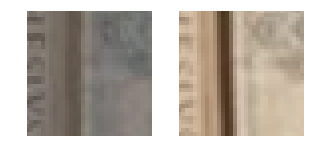

Number of negatives on the same image: 426
Number of negatives on the same image after filtering: 423


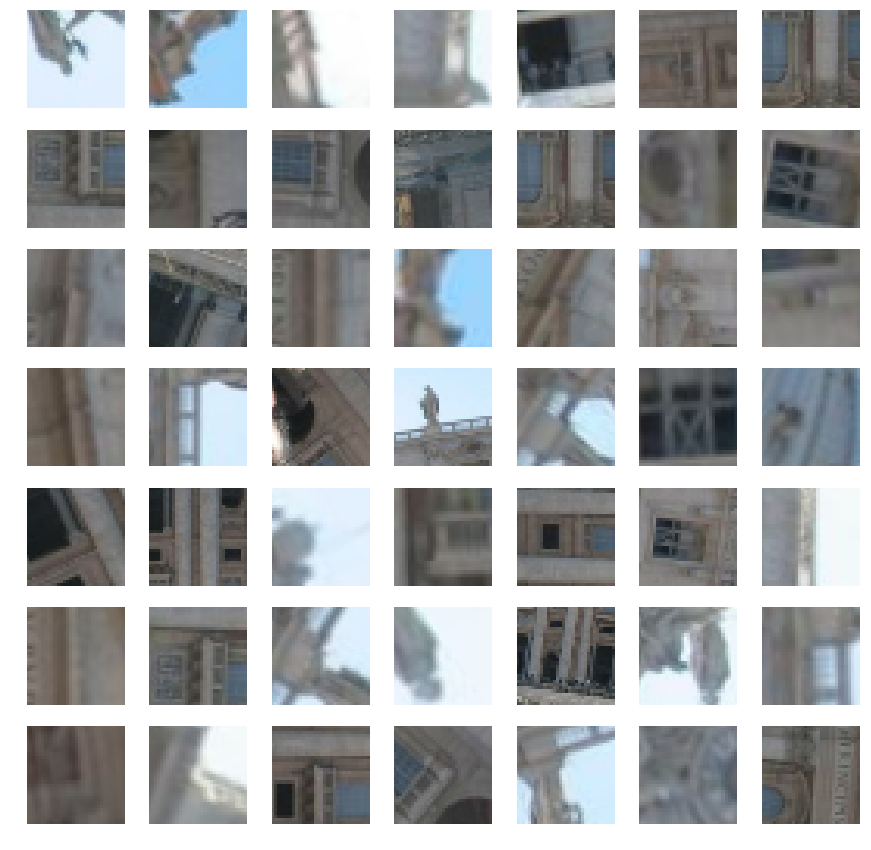

Number of negatives on the matched image: 697
Number of negatives on the matched image after filtering: 690


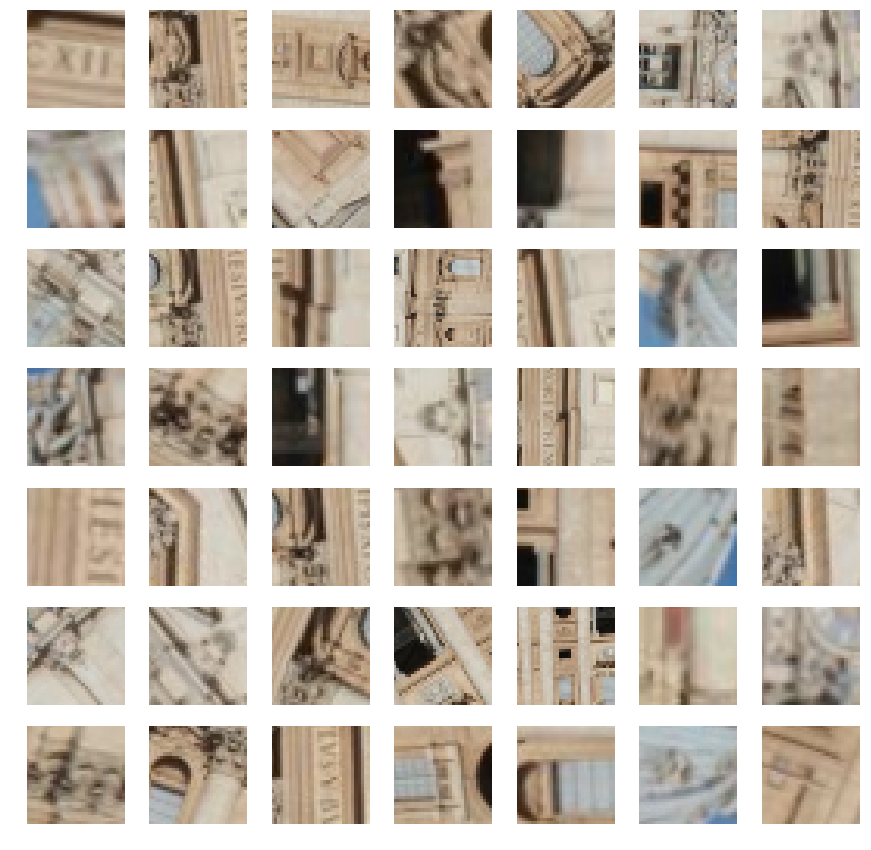

Number of negatives on other sequences: 689002


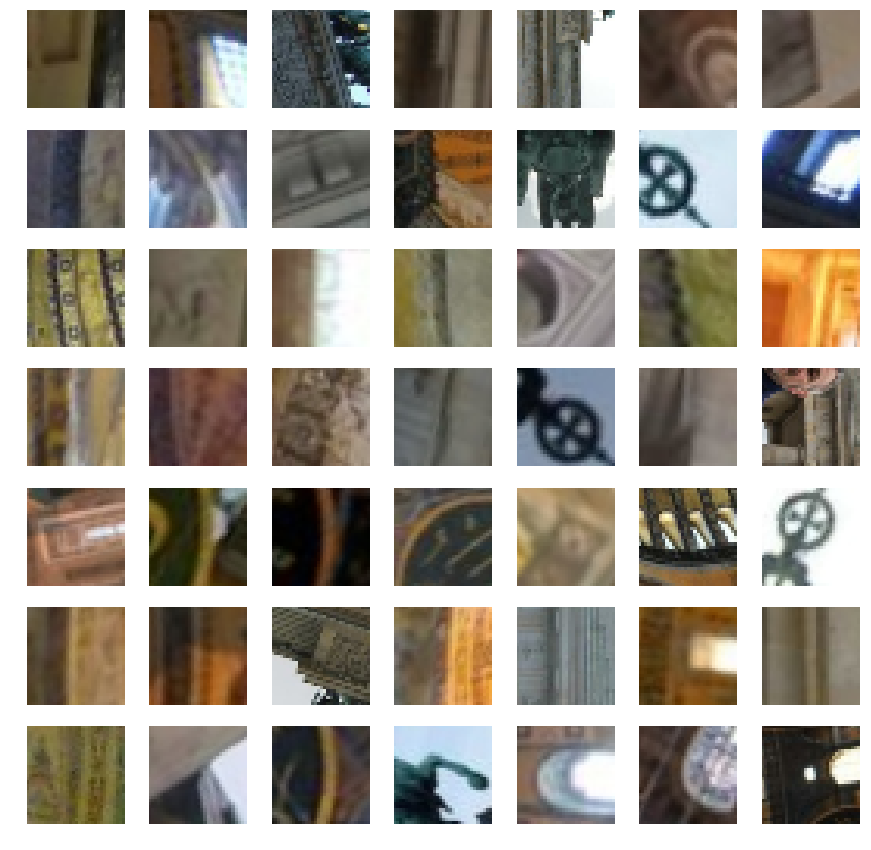

In [27]:
iou_th = 0.25

cur_seqs = np.unique(list_seq)
print(cur_seqs)
print('In dataset:')
for s in cur_seqs:
    print(f'{s} -> "{all_seqs[s]}"')

# number of matches
n = len(metadata) / 2

# pure random sampling
idx = np.random.randint(n)
seq_id = list_seq[idx]
match_id = list_idx[idx]
print(f'Seq {seq_id} -> "{all_seqs[seq_id]}", match {match_id}')

# get the match: this is the nice way to do it
# anchor, pos = np.where((list_idx == match_id) & (list_seq == seq_id))[0]
# this is the quick way as long as you don't shuffle the arrays
anchor, pos = idx, idx + 1 if idx % 2 == 0 else idx - 1

if np.random.binomial(1, 0.5):
    print('flip!')
    anchor, pos = pos, anchor
print(anchor, pos)

fig = plt.figure(figsize=(5,5))
axes = fig.add_subplot(121)
plot_image(axes, patches[anchor])
axes = fig.add_subplot(122)
plot_image(axes, patches[pos])
plt.show()

# cv2.imwrite('/home/trulls/p1.png', patches[anchor])
# cv2.imwrite('/home/trulls/p2.png', patches[pos])

# find negatives on the same image as the anchor
valid = np.where((list_seq == metadata[anchor]['sequence']) & (list_img == metadata[anchor]['image_id']) & (list_idx != match_id))[0]
print(f'Number of negatives on the same image: {len(valid)}')
p1 = metadata[anchor]['loc']
r1 = 6 * metadata[anchor]['scale']
valid_after = []
for v in valid:
    assert v != anchor
    p2 = metadata[v]['loc']
    r2 = 6 * metadata[v]['scale']
    iou = bb_intersection_over_union(
        [p1[0]-r1, p1[1]-r1, p1[0]+r1, p1[1]+r1],
        [p2[0]-r2, p2[1]-r2, p2[0]+r2, p2[1]+r2]
    )
    if iou < iou_th:
        valid_after.append(v)

print(f'Number of negatives on the same image after filtering: {len(valid_after)}')

np.random.shuffle(valid_after)
num_plot = 7
fig = plt.figure(figsize=(15,15))
for i in range(num_plot):
    for j in range(num_plot):
        axes = fig.add_subplot(num_plot, num_plot, 1 + i + j * num_plot)
        if i + j * num_plot < len(valid_after):
            plot_image(axes, patches[valid_after[i + j * num_plot]])
plt.show()

# find negatives on the same image as the positive
valid = np.where((list_seq == metadata[pos]['sequence']) & (list_img == metadata[pos]['image_id']) & (list_idx != match_id))[0]
print(f'Number of negatives on the matched image: {len(valid)}')
p1 = metadata[anchor]['loc_match']
r1 = 6 * metadata[anchor]['scale_match']
valid_after = []
for v in valid:
    assert v != anchor
    p2 = metadata[v]['loc']
    r2 = 6 * metadata[v]['scale']
    iou = bb_intersection_over_union(
        [p1[0]-r1, p1[1]-r1, p1[0]+r1, p1[1]+r1],
        [p2[0]-r2, p2[1]-r2, p2[0]+r2, p2[1]+r2]
    )
    if iou < iou_th:
        valid_after.append(v)

print(f'Number of negatives on the matched image after filtering: {len(valid_after)}')

np.random.shuffle(valid_after)
num_plot = 7
fig = plt.figure(figsize=(15,15))
for j in range(num_plot):
    for i in range(num_plot):
        axes = fig.add_subplot(num_plot, num_plot, 1 + i + j * num_plot)
        if i + j * num_plot < len(valid_after):
            plot_image(axes, patches[valid_after[i + j * num_plot]])
plt.show()

# find negative on another sequence
valid = np.where(list_seq != list_seq[anchor])[0]
print(f'Number of negatives on other sequences: {len(valid)}')
if sum(valid) > 1:
    np.random.shuffle(valid)
    
    num_plot = 7
    fig = plt.figure(figsize=(15,15))
    for i in range(num_plot):
        for j in range(num_plot):
            axes = fig.add_subplot(num_plot, num_plot, 1 + i + j * num_plot)
            if i + j * num_plot < len(valid_after):
                plot_image(axes, patches[valid[i + j * num_plot]])
    plt.show()


In [540]:
# # x = np.zeros((0, 5, 5))
# # y = np.zeros((3, 5, 5))
# # np.concatenate((x, y), axis=0).shape
# print(idx)
# v = np.where(list_idx == idx)[0]
# print(v)
# print([metadata[_v] for _v in v])
# print((list_seq == metadata[anchor]['sequence']).sum())
print((list_img == metadata[anchor]['image_id']).sum())
# print((list_idx != match_id).sum())
print(((list_seq == metadata[anchor]['sequence']) & (list_img == metadata[anchor]['image_id']) & (list_idx != match_id)).sum())



3560
3559


In [3]:
# [(list_img == x).sum() for x in range(100)]
# list_img.max()
print(np.where((list_idx == match_id) & (list_seq == seq_id))[0])
print(idx, idx + 1 if idx % 2 == 0 else idx - 1)

NameError: name 'list_idx' is not defined

(240, 240, 3)


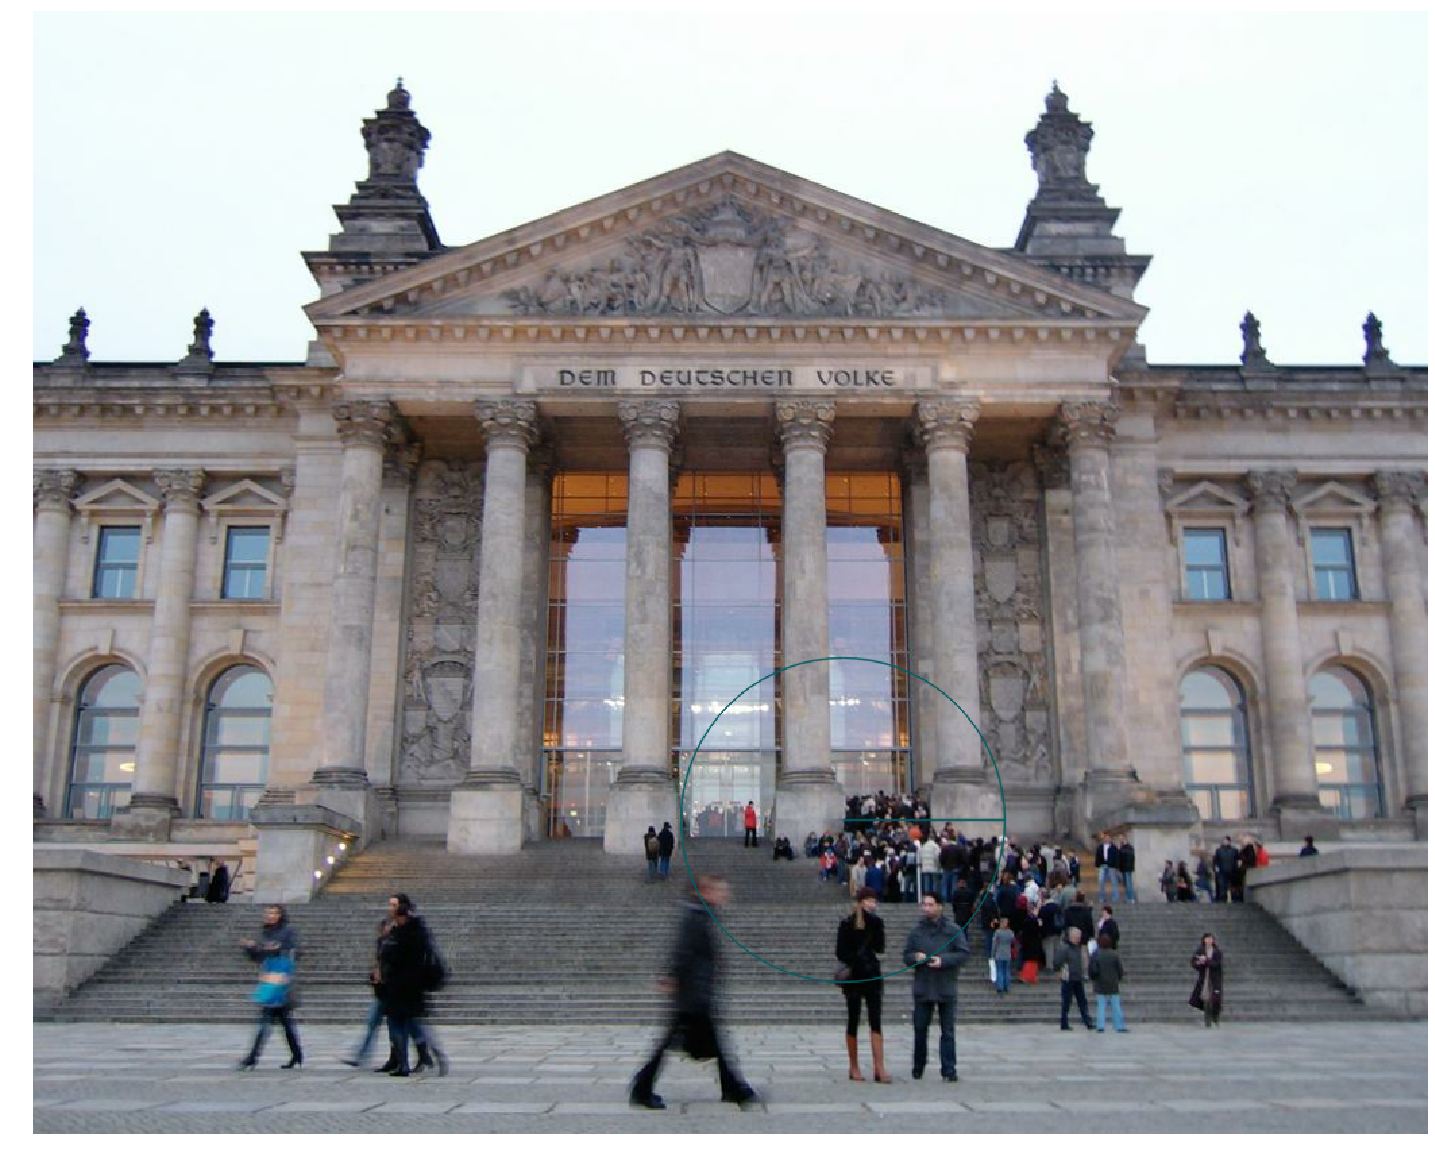

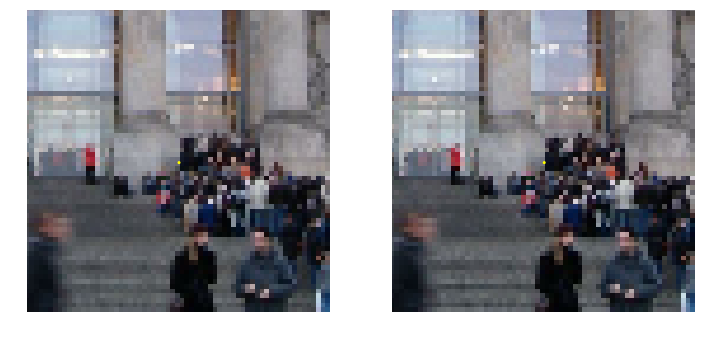

(65, 65, 3)

In [50]:
# ugly check on how good the opencv crops are
from PIL import Image

def custom_crop(im, x, y, scale, patchsize):
    crop = im[
        int(y - scale * patchsize / 2):int(y + scale * patchsize / 2),
        int(x - scale * patchsize / 2):int(x + scale * patchsize / 2),
        :
    ]
    print(crop.shape)
    
    return cv2.resize(crop, dsize=(patchsize, patchsize), interpolation=cv2.INTER_CUBIC)

fn = '/media/trulls/WDMP0827/colmap/reichstag/dense/images/62751178_369337490.jpg'
im = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB)

keypoints = [
    [600, 600, 20, 0],
]

fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111)
cvkp = [cv2.KeyPoint(p[0], p[1], p[2] * 12, p[3]) for p in keypoints]
im_plot = cv2.drawKeypoints(im, cvkp, None, None, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plot_image(axes, im_plot)

lmb = 12
ps = 65
patches = []
patches2 = []
for p in keypoints:
    patch = crop_patch(im, int(p[0]), int(p[1]), p[3], lmb*p[2]/ps, ps)
    patch2 = custom_crop(im, int(p[0]), int(p[1]), lmb*p[2]/ps, ps)
    if patch is not None:
        patches.append(patch)
        patches2.append(patch2)

for patch, patch2 in zip(patches, patches2):
    fig = plt.figure(figsize=(12, 12))
    axes = fig.add_subplot(121)
    plot_image(axes, patch)
    plot_keypoints(axes, [[ps/2, ps/2]], 'yellow')
    axes = fig.add_subplot(122)
    plot_image(axes, patch2)
    plot_keypoints(axes, [[ps/2, ps/2]], 'yellow')
    plt.show()

[ 10.  24.  83.  20.   9.  10.   1.   3.   0.  28.  96.  10.   8.  43.
  23.   2.   0.  21.  36.   5.  10.  17.  48.  13.   5.   1.   2.   7.
  23.  20.  15.   4.   1.   5.  31.  19.  37.  41.  26.   1.  10.  56.
 140.  74. 105.  18.  16.   1. 109. 163. 113.  25.  14.   1.   0.   2.
  24.  11.   4.   8.  13.   3.   8.  10.   7.   1.   0.   3.  54.  20.
  19.   3.  55.   7.   6.  58. 165.  13.   6.   3. 165.  29.   6.  14.
  37.   0.   0.  30.  45.   3.   1.   2.   2.   0.   3.  10.  13.   8.
   1.   6.  64.   0.   0.   1.  63.   3.   0.  34. 165.   1.   0.   7.
 165.  16.   3.   3.  24.   1.   0.  33.  24.   8.  11.   2.   5.   1.
   1.   7.] 511.75287
[[  2   1  32  58   2   7 153  49   1   6 150  39   2   3   9   7   3   3
   18  25   6  20  47  26  34  68 115  17   7   8   8   7   3  11  22   5
   24  31  31   9 153 153 153   8  38  39  16   5   2  26  64   3   5  13
   47   8  11  17  19  10   4   4   8   3   3  21  23   4   4   4   7  12
    3   2   7   9   2   5  15   6   2  17  

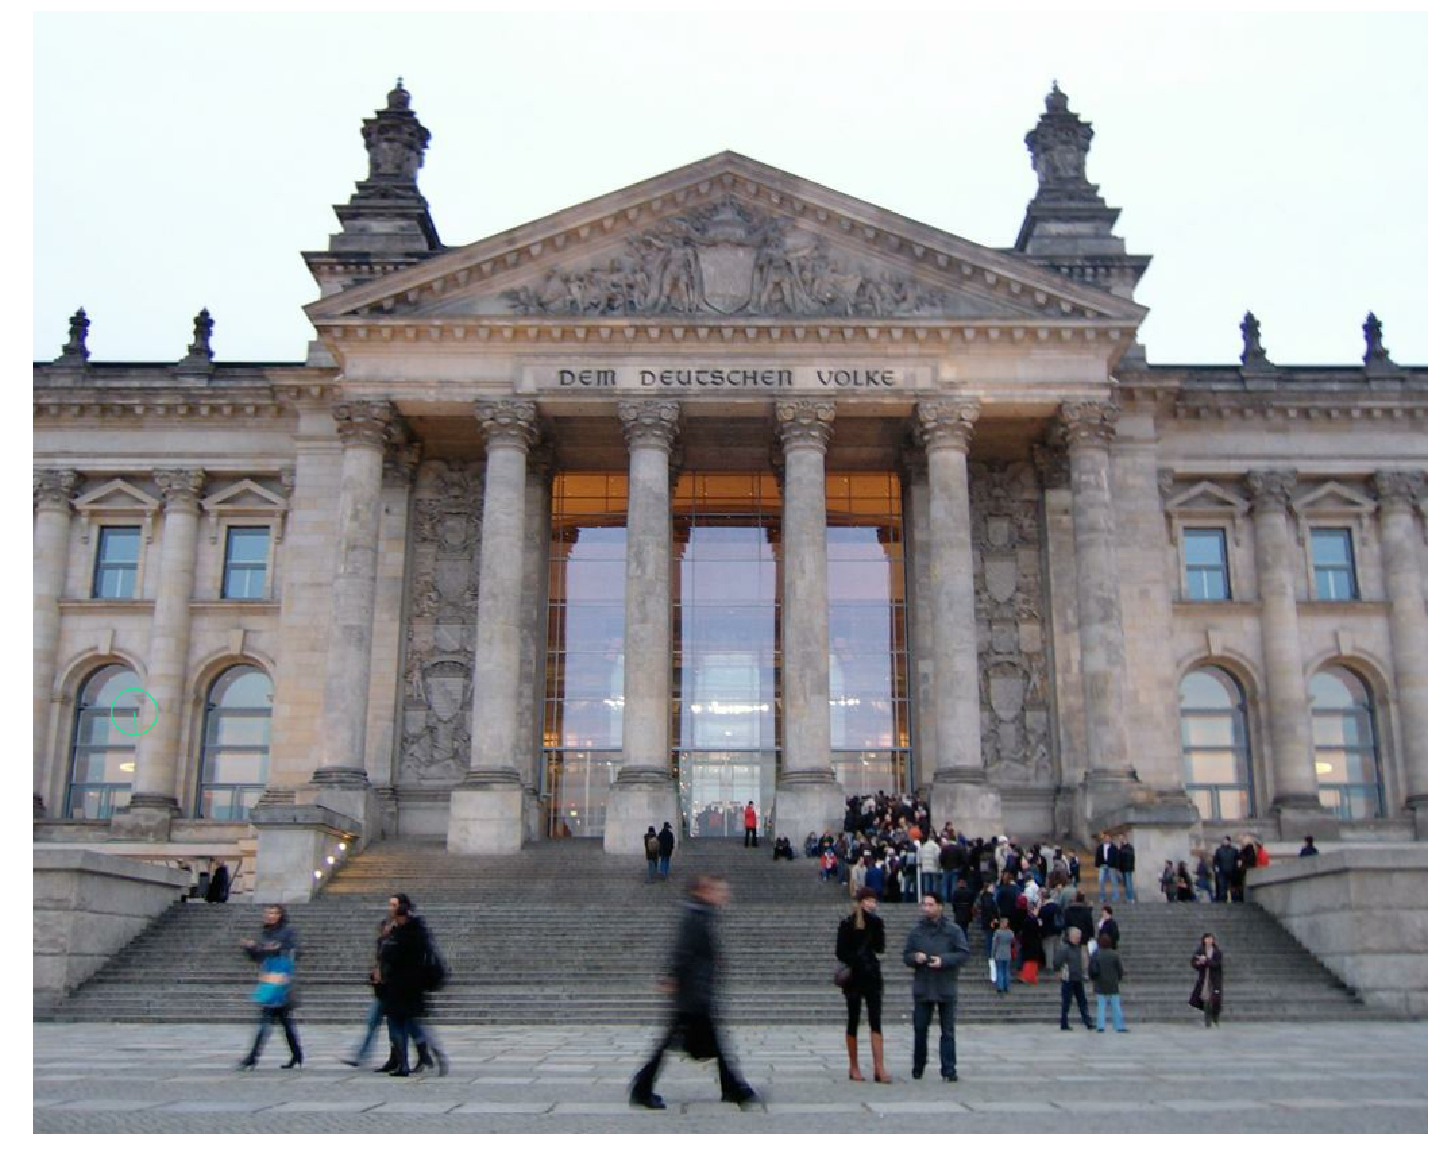

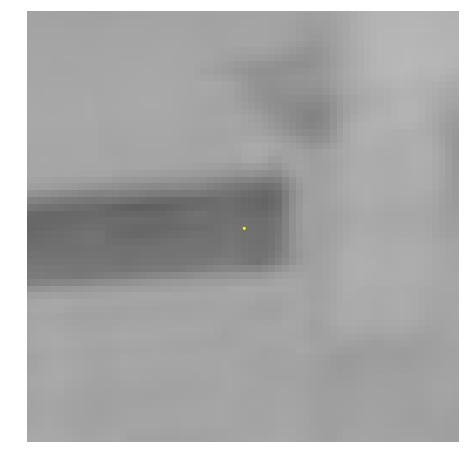

In [94]:
# compare opencv-sift and pytorch-sift
from pytorch_sift.pytorch_sift import SIFTNet
import torch
from torch.autograd import Variable

fn = '/media/trulls/WDMP0827/colmap/reichstag/dense/images/62751178_369337490.jpg'
im = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB)
im_g = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_RGB2GRAY)

lmb = 6
ps = 64
subset = [300]

detector = cv2.xfeatures2d.SIFT_create()
kp_cv, desc_cv = detector.detectAndCompute(im_g, None)

SIFT = SIFTNet(patch_size=ps)
SIFT.eval()

cvkp = []
patches = []
descs = []
for k in subset:
    cvkp.append(cv2.KeyPoint(kp_cv[k].pt[0], kp_cv[k].pt[1], kp_cv[k].size * lmb, kp_cv[k].angle))
    patch = crop_patch(im_g, int(kp_cv[k].pt[0]), int(kp_cv[k].pt[1]), kp_cv[k].angle - 90, lmb*kp_cv[k].size/ps, ps)
    if patch is not None:
        patches.append(patch)
    torch_patch = Variable(torch.from_numpy(patch[None, None, ...].astype(np.float32)))
    res = SIFT(torch_patch)
    sift = np.round(512. * res.data.cpu().numpy()).astype(np.int32)
    descs.append(sift)

fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111)
im_plot = cv2.drawKeypoints(im, cvkp, None, None, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plot_image(axes, im_plot)

for patch in patches:
    fig = plt.figure(figsize=(8, 8))
    axes = fig.add_subplot(111)
    plot_image(axes, cv2.cvtColor(patch, cv2.COLOR_GRAY2RGB))
    plot_keypoints(axes, [[ps/2, ps/2]], 'yellow')

for i, k in enumerate(subset):
    print(desc_cv[k], np.linalg.norm(desc_cv[k]))
    print(descs[i], np.linalg.norm(descs[i]))
    print(np.linalg.norm(descs[i] - desc_cv[k]))
d64 = descs[0]

In [5]:
np.linalg.norm(d32 - d64)

NameError: name 'd32' is not defined

## Generate test splits for the patch dataset

In [25]:
# read sequences
src = '/cvlabdata1/cvlab/datasets_eduard/colmap-patches-fix-dumped/pairs-2000-kps-2000-size-32-thscale-1.25-thori-22.50'
patchsize = 32
seqs = [
#     'british_museum',
    'reichstag',
    'lincoln_memorial_statue',
    'london_bridge',
    'milan_cathedral',
    'mount_rushmore',
    'piazza_san_marco',
    'florence_cathedral_side',
    'sagrada_familia',
    'st_pauls_cathedral',
    'united_states_capitol',
]

metadata = []
for seq in seqs:
    print(f'Loading "{seq}"...')
    metadata += dd.io.load(f'{src}/{seq}-metadata.dd')
print(f'Read {len(metadata)} metadata entries')
    
acc = 0
patches = np.zeros((len(metadata), patchsize, patchsize, 3), dtype=np.uint8)
for seq in seqs:
    with h5py.File(f'{src}/{seq}-patches.h5', 'r') as f:
        patches[acc:acc+f['patches'].shape[0], :, :, :] = f['patches'].value
        print(f'Loading "{seq}": {f["patches"].shape[0]} patches...')
        acc += f['patches'].shape[0]
print(f'Read {patches.shape[0]} patches')

# for easy access
list_seq = np.array([m['sequence'] for m in metadata])
list_idx = np.array([m['match'] for m in metadata])
list_img = np.array([m['image_id'] for m in metadata])

Loading "reichstag"...
Loading "lincoln_memorial_statue"...
Loading "london_bridge"...
Loading "milan_cathedral"...
Loading "mount_rushmore"...
Loading "piazza_san_marco"...
Loading "florence_cathedral_side"...
Loading "sagrada_familia"...
Loading "st_pauls_cathedral"...
Loading "united_states_capitol"...
Read 12336132 metadata entries
Loading "reichstag": 155100 patches...
Loading "lincoln_memorial_statue": 351500 patches...
Loading "london_bridge": 1063650 patches...
Loading "milan_cathedral": 1985708 patches...
Loading "mount_rushmore": 1835560 patches...
Loading "piazza_san_marco": 1250930 patches...
Loading "florence_cathedral_side": 2350220 patches...
Loading "sagrada_familia": 1509252 patches...
Loading "st_pauls_cathedral": 1257976 patches...
Loading "united_states_capitol": 576236 patches...
Read 12336132 patches


In [38]:
# did not generate a pair id, so I hack it together here
list_pair = np.zeros(list_img.size)
last_pair = None
last_seq = None
last_pair = None
cur_pair = -1
counter = 0
for k in range(0, list_img.size, 2):
    update = False
    i, j = list_img[k:k+2]
    counter += 1

    # check for a sequence change
    if list_seq[k] != last_seq:
        update = True
    else:
        # check for changes in the image ids
        if (i, j) != last_pair:
            update = True

    if update:
#         print(f'Pair {cur_pair} has {counter} matches {last_seq}')
        counter = 0
        cur_pair += 1
        
    list_pair[k:k+2] = cur_pair
    last_seq = list_seq[k]
    last_pair = (i, j)
    
print(cur_pair)
print(list_pair[-10:])
# patches_per_pair = np.zeros(cur_pair + 1)
# for i in range(0, cur_pair + 1):
#     patches_per_pair[i] = (list_pair == i).sum()
# print(f'Matches per pair: avg {patches_per_pair.mean()/2}, min {patches_per_pair.min()/2}, max {patches_per_pair.max()/2}')


18035
[18035. 18035. 18035. 18035. 18035. 18035. 18035. 18035. 18035. 18035.]


In [45]:
print(np.where(patches_per_pair == 2)[0])
print(np.where(list_pair == 16)[0])
for i in range(9734, 9744):
    print(i, metadata[i])
print(all_seqs[16])

[   16   285   327   489   529   541   542   682   707   722   812   849
   858   899   935   956  1050  1191  1258  1344  1359  1580  1635  1689
  1699  1768  1875  1919  2048  2088  2115  2123  2144  2151  2347  3191
  4339  4792  4993  5104  5170  6253  6382  6540  6627  6717  6860  6971
  7496  8299  8305  8574  8782  8827  8867  8906  9361  9529  9544  9551
  9838 10037 10057 10071 10075 10792 11756 13289 13643 13787 15625 15875]
[9738 9739]
9734 {'sequence': 16, 'match': 4867, 'image_id': 16, 'image': '63790741_1504116525.jpg', 'loc': array([365.19351196, 262.27532959]), 'scale': 2.9208123683929443, 'loc_match': array([469.5987854 , 479.80664062]), 'scale_match': 2.521629799144986, 'hist_delta_scale': 1.1583033994059357, 'hist_delta_ori': 6.962186751935633}
9735 {'sequence': 16, 'match': 4867, 'image_id': 13, 'image': '92342560_2757258130.jpg', 'loc': array([469.5987854 , 479.80664062]), 'scale': 4.047828674316406, 'loc_match': array([365.19351196, 262.27532959]), 'scale_match': 

In [26]:
# Create stereo data
iou_th = 0.25

cur_seqs = np.unique(list_seq)
print(cur_seqs)
print('In dataset:')
for s in cur_seqs:
    num_img = len(np.unique(list_img[list_seq == s]))
    print(f'{s} -> "{all_seqs[s]}", {num_img} images')

# for each sequence, for each pair, up to 500
stored = []
patches = []
matches = {}
for s in cur_seqs:
    valid_indices = list_seq == s
    valid_pairs = np.unique(list_pair == )
    img_ids = np.unique(list_img[list_seq == s])
    for img_id in img_ids:
        print(f'{img_id} -> {sum(list_img == img_id)/2} points')
        
    break
    
    
# seq_id = list_seq[idx]
# match_id = list_idx[idx]
# print(f'Seq {seq_id} -> "{all_seqs[seq_id]}", match {match_id}')

# # get the match: this is the nice way to do it
# # anchor, pos = np.where((list_idx == match_id) & (list_seq == seq_id))[0]
# # this is the quick way as long as you don't shuffle the arrays
# anchor, pos = idx, idx + 1 if idx % 2 == 0 else idx - 1

# if np.random.binomial(1, 0.5):
#     print('flip!')
#     anchor, pos = pos, anchor
# print(anchor, pos)

# fig = plt.figure(figsize=(5,5))
# axes = fig.add_subplot(121)
# plot_image(axes, patches[anchor])
# axes = fig.add_subplot(122)
# plot_image(axes, patches[pos])
# plt.show()

# # find negatives on the same image as the positive
# valid = np.where((list_seq == metadata[pos]['sequence']) & (list_img == metadata[pos]['image_id']) & (list_idx != match_id))[0]
# print(f'Number of negatives on the matched image: {len(valid)}')
# p1 = metadata[anchor]['loc_match']
# r1 = 6 * metadata[anchor]['scale_match']
# valid_after = []
# for v in valid:
#     assert v != anchor
#     p2 = metadata[v]['loc']
#     r2 = 6 * metadata[v]['scale']
#     iou = bb_intersection_over_union(
#         [p1[0]-r1, p1[1]-r1, p1[0]+r1, p1[1]+r1],
#         [p2[0]-r2, p2[1]-r2, p2[0]+r2, p2[1]+r2]
#     )
#     if iou < iou_th:
#         valid_after.append(v)

# print(f'Number of negatives on the matched image after filtering: {len(valid_after)}')

# np.random.shuffle(valid_after)
# num_plot = 7
# fig = plt.figure(figsize=(15,15))
# for j in range(num_plot):
#     for i in range(num_plot):
#         axes = fig.add_subplot(num_plot, num_plot, 1 + i + j * num_plot)
#         if i + j * num_plot < len(valid_after):
#             plot_image(axes, patches[valid_after[i + j * num_plot]])
# plt.show()


[16 17 18 19 20 21 22 23 24 25]
In dataset:
16 -> "reichstag", 49 images
17 -> "lincoln_memorial_statue", 742 images
18 -> "london_bridge", 447 images
19 -> "milan_cathedral", 111 images
20 -> "mount_rushmore", 125 images
21 -> "piazza_san_marco", 223 images
22 -> "florence_cathedral_side", 104 images
23 -> "sagrada_familia", 374 images
24 -> "st_pauls_cathedral", 530 images
25 -> "united_states_capitol", 177 images
0 -> 59834.5 points
1 -> 57891.0 points
2 -> 65597.0 points
3 -> 40058.5 points
4 -> 50829.0 points
5 -> 28174.0 points
6 -> 44375.5 points
7 -> 47528.0 points
8 -> 45831.0 points
9 -> 30891.0 points
10 -> 66021.5 points
11 -> 75101.0 points
12 -> 33472.5 points
13 -> 55045.0 points


KeyboardInterrupt: 

array([  0,   1,   0, ..., 484, 628, 484])